In [1]:
# Importing necessary libraries
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from scipy import io
import numpy as np
import pycroscopy as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from os.path import join as pjoin
from keras.regularizers import l1
import sys
import glob

from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import math

# Computation:
import h5py

# Visualization:
import matplotlib.colors as colors
import ipywidgets as widgets

from IPython.display import display

import Support_Functions as sf
% matplotlib inline


Using TensorFlow backend.


In [2]:
# function to find a specified layers output
def get_ith_layer_output(model, X, i, mode='test'):
    ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
    return layer_output

In [3]:
# Loading the Model for the Visualization
mods = keras.models.load_model("C:/Users/Josh_/CKPFM_Doped_001_PZT/Autoencoder_folder/amp_no_train_2deep/weights.5000-0.02.hdf5")

In [4]:
mods.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 1)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 256)           133120    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 8)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64, 256)           140288    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64, 256)           394240    
__________

In [5]:
# Importing the experimental data
input_file_path ='D:/PZT001_BEPs_0003.h5' #px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                         #filter='Translated file (*.h5);; \\ Parameters for raw BE data (*.txt *.mat *xls *.xlsx)')

(data_dir, data_name) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = px.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = px.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
print('Working on:\n' + h5_path)

h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[0]

File is already Pycroscopy ready.
Working on:
D:/PZT001_BEPs_0003.h5


In [6]:
# SHO fitting functions or taking previous fit
h5_sho_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
sho_fitter = px.BESHOmodel(h5_main, parallel=True)
if len(h5_sho_group) == 0:
    print('No SHO fit found. Doing SHO Fitting now')
    h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', processors=max_cores)
    h5_sho_fit = sho_fitter.do_fit(processors=max_cores)
else:
    print('Taking previous SHO results already present in file')
    h5_sho_guess = h5_sho_group[-1]['Guess']
    try:
        h5_sho_fit = h5_sho_group[-1]['Fit']
    except KeyError:
        print('Previously computed guess found. Now computing fit')
        h5_sho_fit = sho_fitter.do_fit(processors=max_cores, h5_guess=h5_sho_guess)

Taking previous SHO results already present in file


In [7]:
# Extracting the data channels to a numpy array shape (x, y, voltage step, on/off, cycle #)
(Nd_mat, success) = px.io.hdf_utils.reshape_to_Ndims(h5_sho_fit)
print('Reshape Success = ' + str(success))
print('Nd_mat shape = ', Nd_mat.shape)

phase_offset = Nd_mat[0, 0, 1, 0, 0]['Phase [rad]']

# phase_offset = 0;

print('Phase offset [rad] = ', phase_offset)

Nd_mat[:,:,:,:,:]['Phase [rad]'] = Nd_mat[:,:,:,:,:]['Phase [rad]'] - phase_offset

Reshape Success = True
Nd_mat shape =  (80, 80, 128, 2, 3)
Phase offset [rad] =  0.342565


In [8]:
# normalization function
def norm(indat):
    indat-=np.mean(indat)
    indat/=np.std(indat)
    return indat

In [9]:
# Pulling data channels from Nd_mat to individual arrays, amplitude, phase, frequency, quality factor
amp_off = np.atleast_3d(norm(Nd_mat["Amplitude [V]"][:,:,:,1,2].reshape(-1,128)))
phase_off = np.atleast_3d(norm(Nd_mat["Phase [rad]"][:,:,:,1,2].reshape(-1,128)))
freq_off = np.atleast_3d(norm(Nd_mat["Frequency [Hz]"][:,:,:,1,2].reshape(-1,128)))
qf_off = np.atleast_3d(Nd_mat["Quality Factor"][:,:,:,1,2].reshape(-1,128))

amp_on = np.atleast_3d(norm(Nd_mat["Amplitude [V]"][:,:,:,0,2].reshape(-1,128)))
phase_on = np.atleast_3d(norm(Nd_mat["Phase [rad]"][:,:,:,0,2].reshape(-1,128)))
freq_on = np.atleast_3d(norm(Nd_mat["Frequency [Hz]"][:,:,:,0,2].reshape(-1,128)))
qf_on= np.atleast_3d(norm(Nd_mat["Quality Factor"][:,:,:,0,2].reshape(-1,128)))

In [10]:

amp_off_half = np.atleast_3d(amp_off[:,::2])

In [11]:
# Grabbing the dense layer output
output = get_ith_layer_output(mods, amp_off_half, 2)

In [12]:
# Function to pull the networks activations. 
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


In [13]:
recon_plot = mods.predict([amp_off_half], batch_size = 64)

In [14]:
recon_plot_array = np.asarray(recon_plot)

In [15]:
recon_plot_array.shape

(6400, 64, 1)

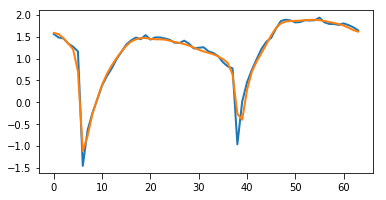

In [16]:
# Quick visual check to see PCA vs raw data
fig, axes = plt.subplots(1,1, figsize=(6,3))

t = np.random.randint(0,3600)
axes.plot(amp_off_half[t,:])
axes.plot(recon_plot_array[t,:])


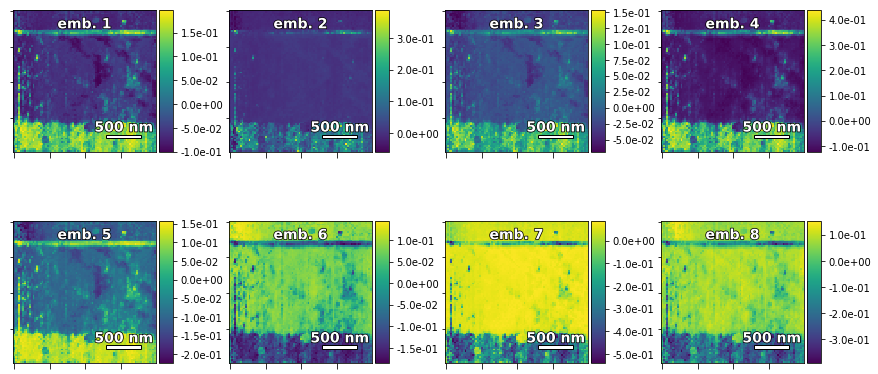

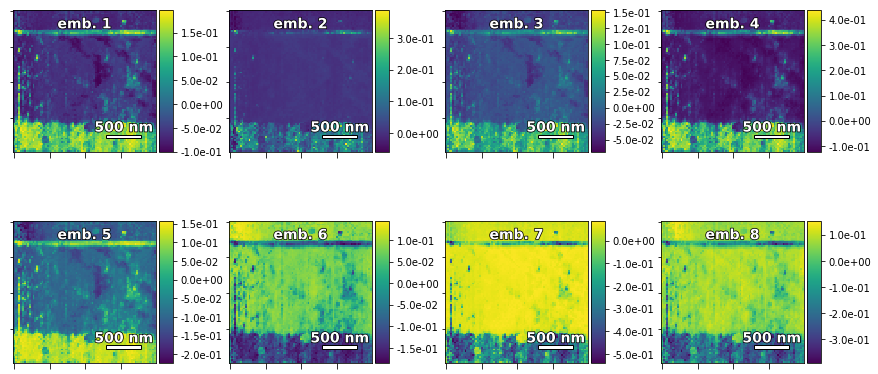

In [17]:
#
sf.plot_embedding_maps(output[:,0:8],
                 add_scalebar=[2000,500],
                 filename='./embedding_maps_1')



In [18]:
#
amp_off_test = np.atleast_3d(norm(Nd_mat["Amplitude [V]"][:,:,:,1,1].reshape(-1,128)))
amp_off_test_half =np.atleast_3d(amp_off_test[:,::2])

In [19]:
amp_off_test_half.shape

(6400, 64, 1)

In [20]:
test_prediction = mods.predict(amp_off_test_half)

In [21]:
mse = ((test_prediction - amp_off_test_half) ** 2).mean()

In [22]:
mse

0.017663501